In [1]:
# Import the required modules
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, RocCurveDisplay

# Pre-Processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("train.csv")
print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# :( 
# Null values
# Category/Strings for columns

In [5]:
# Feature Engineering
df["Has_Cabin"] = df.Cabin.apply(lambda x: True if pd.notnull(x) else False)
df["Family_Size"] = df.SibSp + df.Parch + 1
df["Pclass"] = df.Pclass.astype(str)

In [6]:
# DROP
# Future work: Extract the titles from the NAME column to use as an additional category
cols_to_drop = ["Ticket", "Name", "Cabin", "SibSp", "Parch"]
df.drop(columns=cols_to_drop, inplace=True)

In [7]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked',
       'Has_Cabin', 'Family_Size'],
      dtype='object')

In [8]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Has_Cabin,Family_Size
0,1,0,3,male,22.0,7.2500,S,False,2
1,2,1,1,female,38.0,71.2833,C,True,2
2,3,1,3,female,26.0,7.9250,S,False,1
3,4,1,1,female,35.0,53.1000,S,True,2
4,5,0,3,male,35.0,8.0500,S,False,1


In [9]:
# Define Preprocessing Pipelines

# Define preprocessing for numeric features (Age, Fare, Family_Size) (note that for age, we just use the column median, not split by gender)
numeric_features = ['Age', 'Fare', 'Family_Size'] # You can also do this in a loop, select the numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for the binary features (Sex, Has_Cabin)
binary_features = ['Sex', 'Has_Cabin']
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),
    ('label', OrdinalEncoder())])  # Label encode for binary feature

# Define preprocessing for categorical features (Pclass, Embarked) 
categorical_features = ['Pclass', 'Embarked']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('binary', binary_transformer, binary_features),
        ('cat', categorical_transformer, categorical_features)])

In [10]:
# Correlation Analysis (this is optional and not needed for the ML Experiment)
# It just shows what the data looks like after transformation before training
# We will still declare a full pipeline of preprocessing + training

# Use only preprocessing pipeline to transform the data
preprocessed_X_train = preprocessor.fit_transform(df)

# Convert preprocessed data to a DataFrame
# Get the feature names after one-hot encoding
encoded_feature_names = (numeric_features + binary_features +
                         list(preprocessor.transformers_[2][1]['onehot'].get_feature_names_out(categorical_features)))

df_final = pd.DataFrame(preprocessed_X_train, columns=encoded_feature_names)
df_final["Survived"] = df.Survived
df_final.head()

,Age,Fare,Family_Size,Sex,Has_Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Survived
0,-0.565736,-0.502445,0.059160,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
1,0.663861,0.786845,0.059160,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1
2,-0.258337,-0.488854,-0.560975,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
3,0.433312,0.420730,0.059160,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1
4,0.433312,-0.486337,-0.560975,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0


In [11]:
corrs = df_final.corr()
corrs

,Age,Fare,Family_Size,Sex,Has_Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Survived
Age,1.000000,0.096688,-0.245619,0.081163,0.240314,0.323896,0.015831,-0.291955,0.030248,-0.031415,-0.006729,-0.064910
Fare,0.096688,1.000000,0.217138,-0.182333,0.482075,0.591711,-0.118557,-0.413333,0.269335,-0.117216,-0.162184,0.257307
Family_Size,-0.245619,0.217138,1.000000,-0.200988,-0.009175,-0.046114,-0.038594,0.071142,-0.046215,-0.058592,0.077359,0.016639
Sex,0.081163,-0.182333,-0.200988,1.000000,-0.140391,-0.098013,-0.064746,0.137143,-0.082853,-0.074115,0.119224,-0.543351
Has_Cabin,0.240314,0.482075,-0.009175,-0.140391,1.000000,0.788773,-0.172413,-0.539291,0.208528,-0.129572,-0.101139,0.316912
Pclass_1,0.323896,0.591711,-0.046114,-0.098013,0.788773,1.000000,-0.288585,-0.626738,0.296423,-0.155342,-0.161921,0.285904
Pclass_2,0.015831,-0.118557,-0.038594,-0.064746,-0.172413,-0.288585,1.000000,-0.565210,-0.125416,-0.127301,0.189980,0.093349
Pclass_3,-0.291955,-0.413333,0.071142,0.137143,-0.539291,-0.626738,-0.565210,1.000000,-0.153329,0.237449,-0.015104,-0.322308
Embarked_C,0.030248,0.269335,-0.046215,-0.082853,0.208528,0.296423,-0.125416,-0.153329,1.000000,-0.148258,-0.782742,0.168240
Embarked_Q,-0.031415,-0.117216,-0.058592,-0.074115,-0.129572,-0.155342,-0.127301,0.237449,-0.148258,1.000000,-0.499421,0.003650


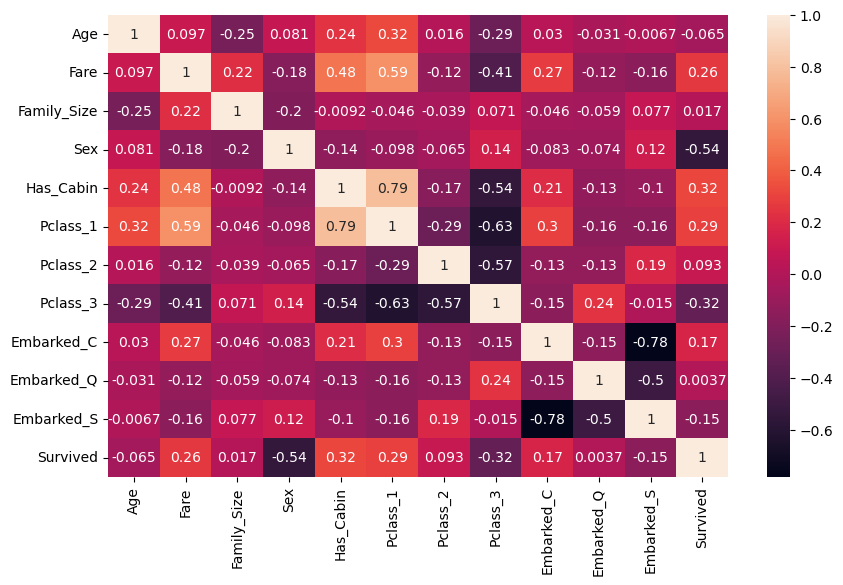

In [12]:
plt.figure(figsize=(10,6))
sns.heatmap(corrs, annot=True)
plt.show()

In [13]:
abs(corrs.Survived).sort_values(ascending=False)

Survived       1.000000
Sex            0.543351
Pclass_3       0.322308
Has_Cabin      0.316912
Pclass_1       0.285904
Fare           0.257307
Embarked_C     0.168240
Embarked_S     0.149683
Pclass_2       0.093349
Age            0.064910
Family_Size    0.016639
Embarked_Q     0.003650
Name: Survived, dtype: float64

In [14]:
# Copy/Paste Gauntlet

In [15]:
df.Survived.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [16]:
# Step 1: Get the data (NOTE: this is the original dataframe, not the one used for the correlations)
X = df.drop(columns=["Survived", "PassengerId"])
y = df.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y) # stratify=True maintains target class percentages
print(X_train.shape, X_test.shape)

(668, 7) (223, 7)


In [17]:
X_train.head() # NOTE: THIS IS UNSCALED & UNENCODED

,Pclass,Sex,Age,Fare,Embarked,Has_Cabin,Family_Size
806,1,male,39.0,0.000,S,True,1
747,2,female,30.0,13.000,S,False,1
292,2,male,36.0,12.875,C,True,1
781,1,female,17.0,57.000,S,True,2
282,3,male,16.0,9.500,S,False,1


In [19]:
y_train.head()

806    0
747    1
292    0
781    1
282    0
Name: Survived, dtype: int64

In [ ]:
# Function for Classification
# THE ROC CURVE CODE WILL BREAK FOR MULTI_CLASS PROBLEMS
def doClassification(model, X_train, X_test, y_train, y_test):
    # Step 3: Fit the model
    model.fit(X_train, y_train)
    
    # Step 4: Evaluate the model
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]

    # Generate metrics TRAIN
    train_cf = confusion_matrix(y_train, train_preds)
    train_cr = classification_report(y_train, train_preds)
    train_auc = roc_auc_score(y_train, train_proba)
    
    train_results = f"""TRAIN METRICS
    Confusion Matrix: 
    {train_cf}
    
    AUC: {train_auc}

    Classification Report:
    {train_cr}
    """
    
    print(train_results)

    # Generate metrics TEST
    test_cf = confusion_matrix(y_test, test_preds)
    test_cr = classification_report(y_test, test_preds)
    test_auc = roc_auc_score(y_test, test_proba)
    
    test_results = f"""TEST METRICS
    Confusion Matrix: 
    {test_cf}
    
    AUC: {test_auc}

    Classification Report:
    {test_cr}
    """
    
    print(test_results)

    # VISUALIZE TEST RESULTS
    # Confusion Matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(test_cf, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test.values, test_proba)
    
    # Set figure size
    plt.figure(figsize=(6, 6))
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {test_auc:.2f})')
    
    # Plot the diagonal reference line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    
    # Titles and labels
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Add grid and legend
    plt.grid(linestyle="--", color="lightgrey", alpha=0.75)
    plt.legend(loc="lower right")
    
    # Display the plot
    plt.show()

In [ ]:
# Step 2: Init the Model
lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Do Machine Learning
doClassification(lr, X_train, X_test, y_train, y_test)

In [ ]:
# Step 2: Init the Model
dt = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Do Machine Learning
doClassification(dt, X_train, X_test, y_train, y_test)

In [ ]:
# Step 2: Init the Model
rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Do Machine Learning
doClassification(rf, X_train, X_test, y_train, y_test)

In [ ]:
# Step 2: Init the Model
svc = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True))
])

# Do Machine Learning
doClassification(svc, X_train, X_test, y_train, y_test)

In [ ]:
# Step 2: Init the Model
knn = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=15))
])

# Do Machine Learning
doClassification(knn, X_train, X_test, y_train, y_test)

In [ ]:
# Step 2: Init the Model
et = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', ExtraTreesClassifier(random_state=42))
])

# Do Machine Learning
doClassification(et, X_train, X_test, y_train, y_test)

In [ ]:
# Step 2: Init the Model
ada = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(random_state=42))
])

# Do Machine Learning
doClassification(ada, X_train, X_test, y_train, y_test)

In [ ]:
# Step 2: Init the Model
gb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Do Machine Learning
doClassification(gb, X_train, X_test, y_train, y_test)

In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
# Step 2: Init the Model
xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])

# Do Machine Learning
doClassification(xgb, X_train, X_test, y_train, y_test)

In [ ]:
# Step 2: Init the Model
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42, verbose=-1))
])

# Do Machine Learning
doClassification(lgbm, X_train, X_test, y_train, y_test)

In [ ]:
fi = pd.DataFrame(list(zip(X.columns, gb.named_steps['classifier'].feature_importances_)), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False)

In [ ]:
fi = pd.DataFrame(list(zip(X.columns, xgb.named_steps['classifier'].feature_importances_)), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False)

In [ ]:
fi = pd.DataFrame(list(zip(X.columns, lgbm.named_steps['classifier'].feature_importances_ / sum(lgbm.named_steps['classifier'].feature_importances_))), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False)

In [ ]:
fi = pd.DataFrame(list(zip(X.columns, ada.named_steps['classifier'].feature_importances_)), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False)

In [ ]:
# Gradient Boosting is probably Best

In [ ]:
# Do Cross Validation to evaluate the model on the ENTIRE dataset
# Were we biased by our random split?
# This is also a good way to test out a few close algorithms on a single metric

In [ ]:
# Create a pipeline with a scaler and a logistic regression model
lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Perform 5-fold cross-validation with roc_auc scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(lr, X, y, cv=cv, scoring='roc_auc')

# Output the results
print(f"Cross-validation AUC scores: {cv_scores}")
print(f"Mean AUC: {np.mean(cv_scores):.3f}")

In [ ]:
# Create a pipeline with a scaler and a logistic regression model
ada = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(random_state=42))
])

# Perform 5-fold cross-validation with roc_auc scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(ada, X, y, cv=cv, scoring='roc_auc')

# Output the results
print(f"Cross-validation AUC scores: {cv_scores}")
print(f"Mean AUC: {np.mean(cv_scores):.3f}")

In [ ]:
# Create a pipeline with a scaler and a logistic regression model
gb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Perform 5-fold cross-validation with roc_auc scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(gb, X, y, cv=cv, scoring='roc_auc')

# Output the results
print(f"Cross-validation AUC scores: {cv_scores}")
print(f"Mean AUC: {np.mean(cv_scores):.3f}")

In [ ]:
# Create a pipeline with a scaler and a logistic regression model
xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])

# Perform 5-fold cross-validation with roc_auc scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(xgb, X, y, cv=cv, scoring='roc_auc')

# Output the results
print(f"Cross-validation AUC scores: {cv_scores}")
print(f"Mean AUC: {np.mean(cv_scores):.3f}")

In [ ]:
# Create a pipeline with a scaler and a logistic regression model
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42, verbose=-1))
])

# Perform 5-fold cross-validation with roc_auc scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(lgbm, X, y, cv=cv, scoring='roc_auc')

# Output the results
print(f"Cross-validation AUC scores: {cv_scores}")
print(f"Mean AUC: {np.mean(cv_scores):.3f}")

In [ ]:
# Gradient Boosting is Best AUC when evaluated using KFold Cross Validation
# (it also has highest accuracy if swap roc_auc with accuracy)

In [ ]:
# Part 3: Model Productionalization

In [ ]:
# Retrain the model on the ENTIRE dataset
gb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])
gb.fit(X, y)

In [ ]:
# Save off my models
import pickle

# Model
pickle.dump(gb, open("titanic_model_pipeline2.h5", 'wb'))

In [ ]:
# Production Use Case

In [ ]:
df_test = pd.read_csv("test.csv")
df_test.head()

In [ ]:
df_test.info()

In [ ]:
# Combine SibSp + Parch to create ONE column for family_size
df_test["Has_Cabin"] = df_test.Cabin.apply(lambda x: True if pd.notnull(x) else False)
df_test["Family_Size"] = df_test.SibSp + df_test.Parch + 1
df_test["Pclass"] = df_test.Pclass.astype(str)
df_test.drop(columns=["Cabin", "SibSp", "Parch", "Name", "Ticket"], inplace=True)

# Save IDs for later
ids = df_test.PassengerId
df_test.drop(columns=["PassengerId"], inplace=True)
df_test.head()

In [ ]:
# NOTE: by putting all of the pre-processing into a pipeline, it is less management to deal with
# at the production state

In [ ]:
# model
model = pickle.load(open("titanic_model_pipeline2.h5", 'rb'))

# columns in order
df_test = df_test.loc[:, ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Has_Cabin', 'Family_Size']]

preds = model.predict(df_test)
preds

In [ ]:
submission = pd.DataFrame()
submission["PassengerId"] = ids
submission["Survived"] = preds
submission.head()

In [ ]:
submission.to_csv("titanic_submission3.csv", index=False)